# Laboratory #08 : Image Classification using CNN

At the end of this laboratory, you would get familiarized with

*   Creating deep networks using Keras
*   Steps necessary in training a neural network
*   Prediction and performance analysis using neural networks
*   Using pre-trained networks

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

# **Students** (First Name and Last Name)

1.   Eva Veli
2.   Tatevik Davtyan

---

# **Colaboratory environment**
By default, Colab notebooks run on CPU.
You can switch your notebook to run with GPU.

In order to obtain access to the GPU, you need to choose the tab Runtime and then select “Change runtime type” as shown in the following figure:

![Changing runtime](https://miro.medium.com/max/747/1*euE7nGZ0uJQcgvkpgvkoQg.png)

When a pop-up window appears select GPU. Ensure “Hardware accelerator” is set to GPU.

In [ ]:
import numpy as np
import seaborn as sns
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, AveragePooling2D, UpSampling2D, Resizing,Input
from keras.optimizers import SGD
from keras.applications import InceptionV3
from keras.applications import ResNet50
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import preprocessing

# **Working with a new dataset: CIFAR-10**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.
There are 50000 training images and 10000 test images. More information about CIFAR-10 can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

In Keras, the CIFAR-10 dataset is also preloaded in the form of four Numpy arrays. x_train and y_train contain the training set, while x_test and y_test contain the test data. The images are encoded as Numpy arrays and their corresponding labels ranging from 0 to 9.

Your task is to:

*   Visualize the images in CIFAR-10 dataset. Create a 10 x 10 plot showing 10 random samples from each class.
*   Convert the labels to one-hot encoded form.
*   Normalize the images.




170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


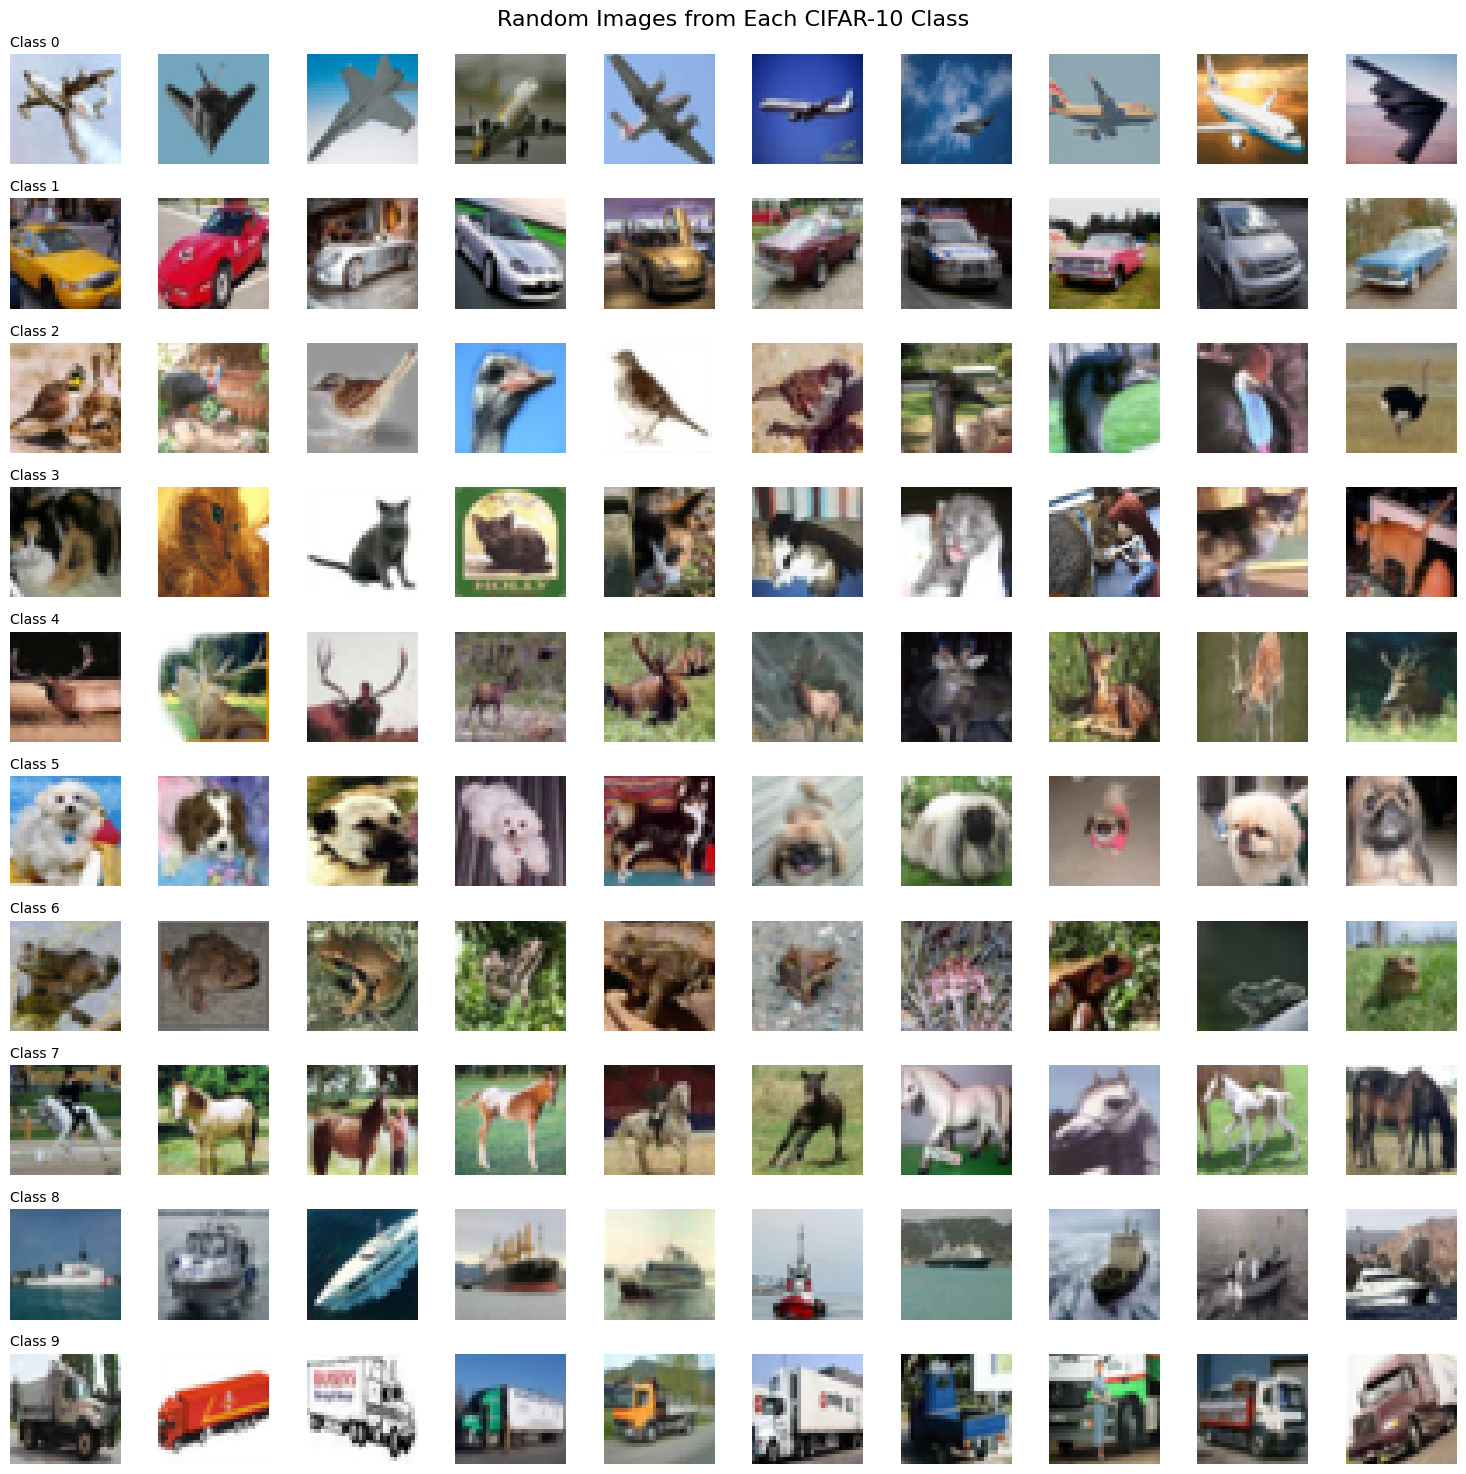

In [ ]:
#Step 1 - Visualize the images in CIFAR-10 dataset. Create a 10 x 10 plot showing 10 random samples from each class.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.squeeze()
y_test = y_test.squeeze()

num_classes = len(np.unique(y_train))  # Number of unique labels (classes)

selected_images = []  # Store selected images
selected_labels = []  # Store corresponding labels
images_per_class = 10  # Number of random images per class

# Iterate through each class label
for class_label in range(num_classes):
    class_indices = np.where(y_train == class_label)[0]  # Indices of images in the current class
    random_class_indices = np.random.choice(class_indices, images_per_class, replace=False)  # Select random images
    for img in x_train[random_class_indices]:  # Add selected images and labels
        selected_images.append(img)
        selected_labels.append(class_label)

# Plot the images
fig, axes = plt.subplots(num_classes, images_per_class, figsize=(15, 15))
fig.suptitle("Random Images from Each CIFAR-10 Class", fontsize=16)

for row in range(num_classes):  # Iterate through rows (classes)
    for col in range(images_per_class):  # Iterate through columns (random images per class)
        ax = axes[row, col]
        img_idx = row * images_per_class + col
        ax.imshow(selected_images[img_idx])  # Display the image
        ax.axis('off')
        if col == 0:  # Add label as a row title
            ax.set_title(f"Class {selected_labels[img_idx]}", fontsize=10, loc='left')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


In [ ]:
# Normalize the images
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
#Convert the labels to one-hot encoded form
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


## Define the following model (same as the one in tutorial)

**For the convolutional front-end, start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. Use the input as (32,32,3). The filter maps can then be flattened to provide features to the classifier. Use a dense layer with 100 units before the classification layer (which is also a dense layer with softmax activation).**

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
# solution
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3), padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         819,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 821,206 (3.13 MB)

 Trainable params: 821,206 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

*   Compile the model using categorical_crossentropy loss, SGD optimizer and use 'accuracy' as the metric.
*   Use the above defined model to train CIFAR-10 and train the model for 20 epochs with a batch size of 512.

In [ ]:
# solution
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=512, validation_split=0.15, epochs=20)


Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1867 - loss: 2.2557 - val_accuracy: 0.1015 - val_loss: 5.9514
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2634 - loss: 2.2629 - val_accuracy: 0.1265 - val_loss: 3.1646
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3087 - loss: 2.0356 - val_accuracy: 0.1316 - val_loss: 2.9572
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3260 - loss: 1.9415 - val_accuracy: 0.1137 - val_loss: 3.6628
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3327 - loss: 1.9867 - val_accuracy: 0.1285 - val_loss: 2.8989
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3585 - loss: 1.8669 - val_accuracy: 0.2439 - val_loss: 2.0943
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3817 - loss: 1.7626 - val_accuracy: 0.1691 - val_loss: 2.7521
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3790 - loss: 1.7920 - val_accuracy: 0.1868 - v

* What is the role of "validation_split" parameter?

**Solution**

The validation_split parameter in the model.fit() function specifies the proportion of the training data to be set aside for validation during training. For example, if validation_split=0.15 and the training data contains 10,000 samples, 1,500 samples (15%) are used for validation, and the remaining 8,500 samples are used for training.

...

Since in our previous example we are using just 20 epochs, the model does not have the opportunity to learn a lot from the training data. If we increase the number of epoch to 150, we can see that the accuracy increases but we have to be careful to avoid overfitting.

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history_more_epochs = model.fit(x_train, y_train, batch_size=512, epochs=150, validation_split=0.15)

Epoch 1/150
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4412 - loss: 1.6917 - val_accuracy: 0.2095 - val_loss: 2.3202
Epoch 2/150
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4605 - loss: 1.5443 - val_accuracy: 0.3471 - val_loss: 1.9360
Epoch 3/150
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4740 - loss: 1.5003 - val_accuracy: 0.3656 - val_loss: 1.7478
Epoch 4/150
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4828 - loss: 1.4747 - val_accuracy: 0.2751 - val_loss: 2.4400
Epoch 5/150
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4743 - loss: 1.5308 - val_accuracy: 0.2601 - val_loss: 2.4040
Epoch 6/150
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4736 - loss: 1.5074 - val_accuracy: 0.1976 - val_loss: 3.0760
Epoch 7/150
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4727 - loss: 1.5502 - val_accuracy: 0.2993 - val_loss: 2.1420
Epoch 8/150
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4919 - loss: 1.4551 - val_accuracy: 0.2

# Defining Deeper Architectures: VGG Models

*   Define a deeper model architecture for CIFAR-10 dataset and train the new model for 20 epochs with a batch size of 512. We will use VGG model as the architecture.

**Stack two convolutional layers with 32 filters, each of 3 x 3. Use a max pooling layer and next flatten the output of the previous layer and add a dense layer with 128 units before the classification layer. For all the layers, use ReLU activation function. Use same padding for the layers to ensure that the height and width of each layer output matches the input**


In [ ]:
clear_session()

In [ ]:
# solution
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3), padding="same"))
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3), padding="same"))
model2.add(MaxPooling2D((2, 2), padding="same"))
model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(10, activation='softmax'))
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,060,138 (4.04 MB)

 Trainable params: 1,060,138 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

*   Compile the model using categorical_crossentropy loss, SGD optimizer and use 'accuracy' as the metric.
*   Use the above defined model to train CIFAR-10 and train the model for 20 epochs with a batch size of 512.

In [ ]:
# solution
model2.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, batch_size=512, validation_split=0.15, epochs=20)

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1802 - loss: 2.2444 - val_accuracy: 0.1337 - val_loss: 2.5830
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2813 - loss: 2.0231 - val_accuracy: 0.1747 - val_loss: 3.6767
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.3268 - loss: 2.0235 - val_accuracy: 0.1065 - val_loss: 4.1054
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.3452 - loss: 1.9741 - val_accuracy: 0.0973 - val_loss: 5.4914
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3685 - loss: 2.0154 - val_accuracy: 0.1028 - val_loss: 4.8130
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3785 - loss: 1.9357 - val_accuracy: 0.2547 - val_loss: 2.3304
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4222 - loss: 1.6805 - val_accuracy: 0.2005 - val_loss: 2.7485
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4258 - loss: 1.6655 - val_accuracy: 0.3539 - v

*   Compare the performance of both the models by plotting the loss and accuracy curves of both the training steps. Does the deeper model perform better? Comment on the observation.


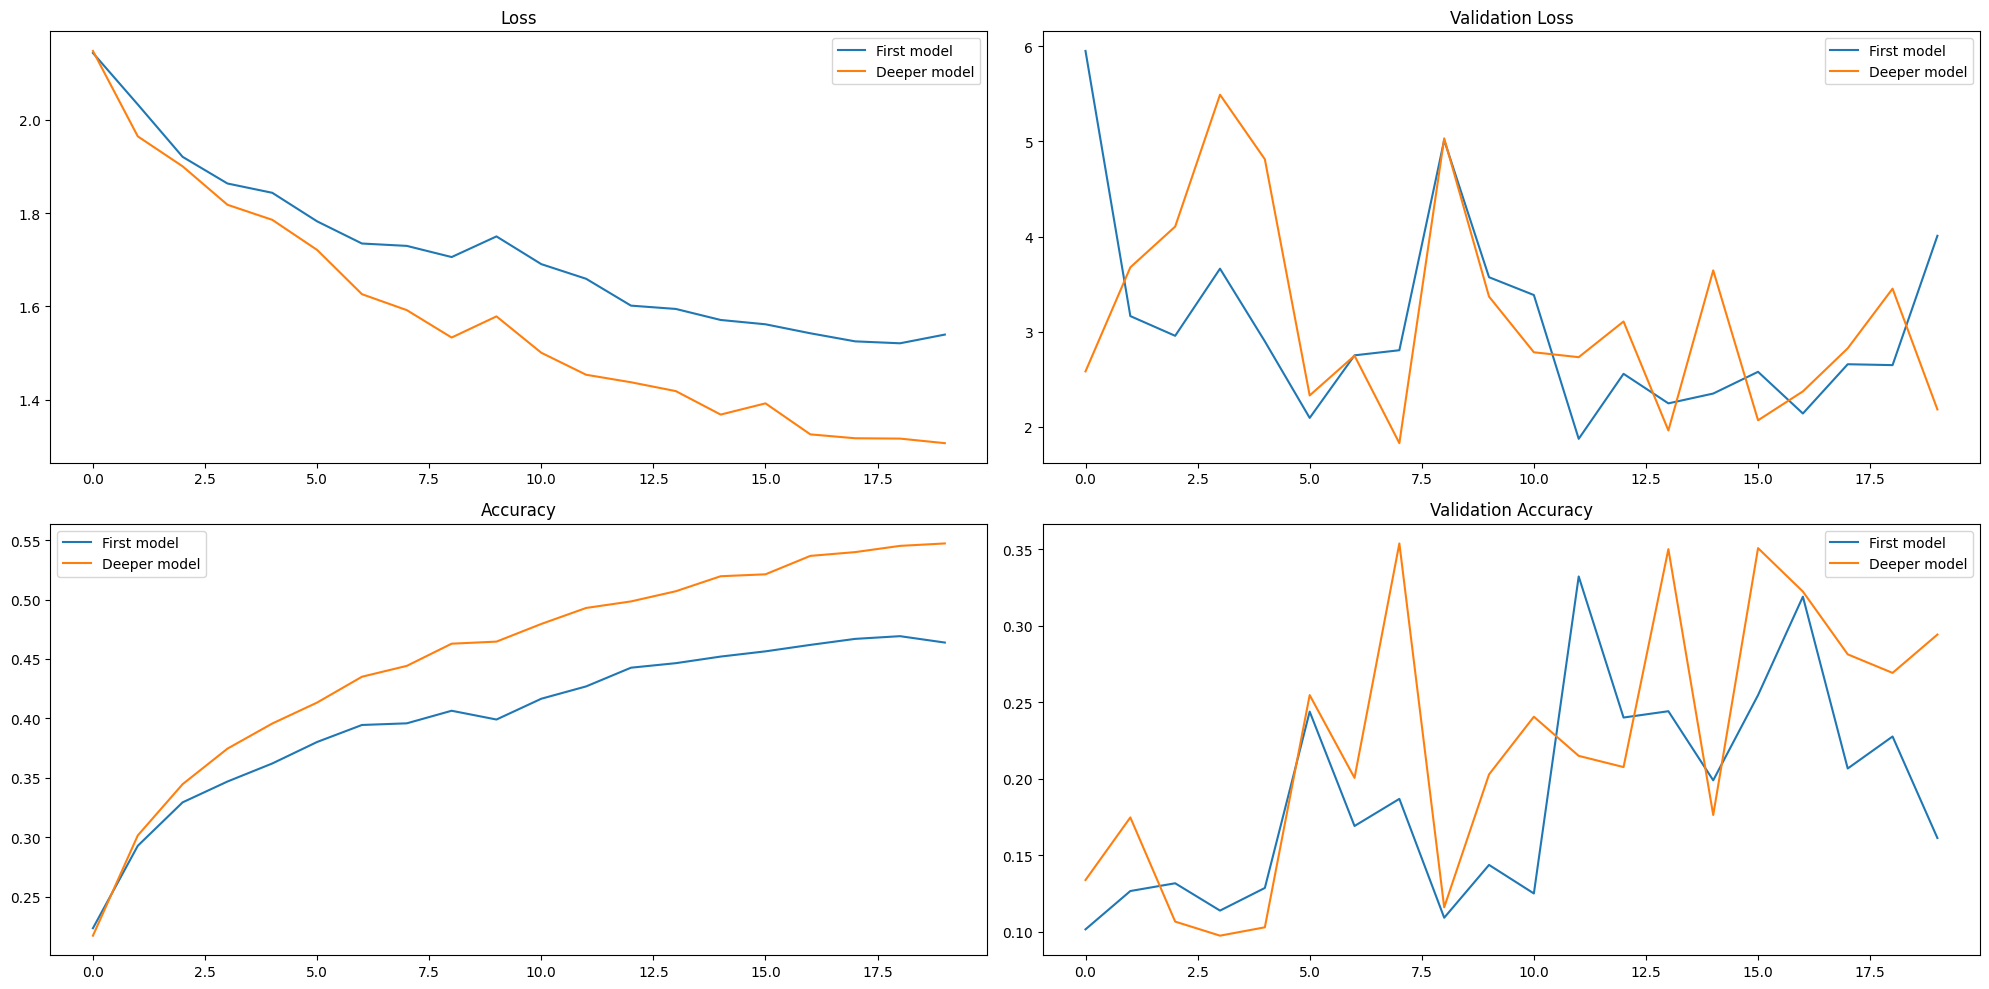

In [ ]:
# solution
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Loss
axs[0, 0].set_title('Loss')
axs[0, 0].plot(history.history['loss'], label='First model')
axs[0, 0].plot(history2.history['loss'], label='Deeper model')
axs[0, 0].legend()

# Validation Loss
axs[0, 1].set_title('Validation Loss')
axs[0, 1].plot(history.history['val_loss'], label='First model')
axs[0, 1].plot(history2.history['val_loss'], label='Deeper model')
axs[0, 1].legend()

# Accuracy
axs[1, 0].set_title('Accuracy')
axs[1, 0].plot(history.history['accuracy'], label='First model')
axs[1, 0].plot(history2.history['accuracy'], label='Deeper model')
axs[1, 0].legend()

# Validation Accuracy
axs[1, 1].set_title('Validation Accuracy')
axs[1, 1].plot(history.history['val_accuracy'], label='First model')
axs[1, 1].plot(history2.history['val_accuracy'], label='Deeper model')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


**Solution**

In the first image we can see that the First Model and Deeper Model show a steady decrease in training loss over epochs. The Deeper Model has a consistently lower training loss compared to the First Model, indicating that it fits the training data better.

 Regarding the validation loss, it is highly erratic for both models, with large fluctuations. While the Deeper Model often achieves lower validation loss compared to the First Model, the instability suggests that both models may have poor generalization or are sensitive to validation data. This could indicate overfitting, especially for the Deeper Model, which has lower training loss but fluctuating validation loss.

 The Deeper Model outperforms the First Model in training accuracy, achieving higher values consistently.The First Model's slower improvement in accuracy indicates that it might have less capacity to fit the training data compared to the Deeper Model.

 Validation accuracy fluctuates significantly for both models. The Deeper Model reaches higher peaks in validation accuracy but also experiences more extreme drops, suggesting it might be overfitting or have poor stability.

 We can say that the Deeper Model performs better but a "better" model is one that balances good performance on both training and validation datasets. While the Deeper Model fits the training data better, its unstable validation performance indicates it may not generalize well.



*   Use predict function to predict the output for the test split
*   Plot the confusion matrix for the new model and comment on the class confusions.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


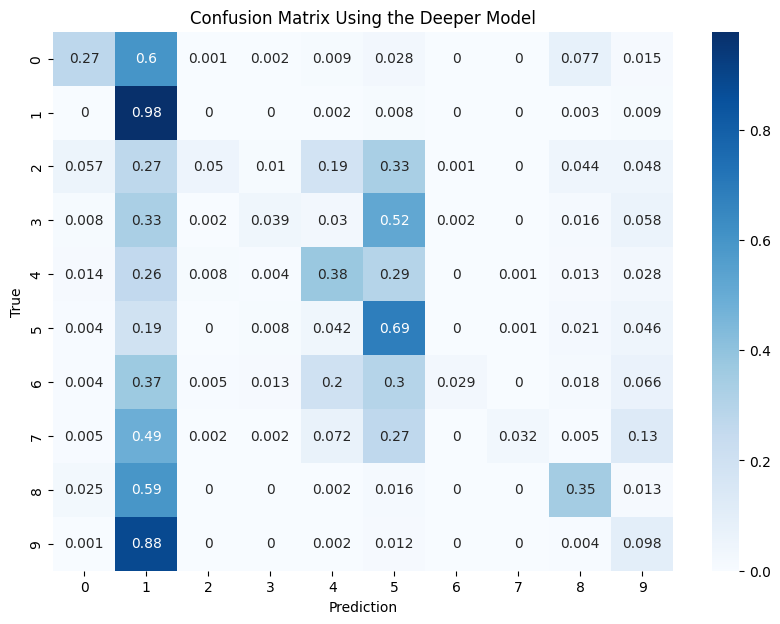

In [ ]:
# solution
y_test_pred = model2.predict(x_test)
y_test_pred_label = np.argmax(y_test_pred, axis=1)
y_test_label = np.argmax(y_test, axis=1)

fig, axs = plt.subplots(figsize=(10, 7))
conf_matrix = confusion_matrix(y_test_label, y_test_pred_label, normalize="true")

# Plotting without categories
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.ylabel("True")
plt.xlabel("Prediction")
plt.title("Confusion Matrix Using the Deeper Model")
plt.show()


**Solution**

 The model performs exceptionally well for certain classes, such as Class 1, which achieves nearly perfect accuracy (98%), indicating the model's ability to effectively learn distinct patterns for that class. However, it struggles significantly with other classes, such as Class 9, where only 9.8% of predictions are correct, and Class 7, which shows substantial confusion with Class 1 (49%) and other classes. Misclassifications are particularly prominent between specific classes, such as Class 0 being confused with Class 1 (60%) and Class 9 being heavily misclassified as Class 1 (88%). These results suggest that the model might be overfitting to dominant classes, such as Class 1, with overlapping features, while underperforming for those with less representation or more subtle distinctions.



*    Print the test accuracy for the trained model.

In [ ]:
# solution
test_loss, test_acc = model2.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2855 - loss: 2.2028
Test loss: 2.185281991958618
Test accuracy: 0.29100000858306885


## Define the complete VGG architecture.

**Stack two convolutional layers with 64 filters, each of 3 x 3 followed by max pooling layer. Stack two more convolutional layers with 128 filters, each of 3 x 3, followed by max pooling, follwed by two more convolutional layers with 256 filters, each of 3 x 3, followed by max pooling. Flatten the output of the previous layer using Global average pooling and add a dense layer with 128 units before the classification layer. For all the layers, use ReLU activation function. Use same padding for the layers to ensure that the height and width of each layer output matches the input**

*   Change the size of input to 64 x 64.

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
# solution
model3 = Sequential()
model3.add(Input(shape=(32, 32, 3)))
model3.add(UpSampling2D((2, 2))) # to have 64x64 images we need to have the scaling factor equal to 2
model3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding="same"))
model3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding="same"))
model3.add(MaxPooling2D((2, 2),padding="same"))
model3.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding="same"))
model3.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding="same"))
model3.add(MaxPooling2D((2, 2),padding="same"))
model3.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding="same"))
model3.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding="same"))
model3.add(MaxPooling2D((2, 2),padding="same"))
model3.add(GlobalAveragePooling2D())
model3.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dense(10, activation='softmax'))


In [ ]:
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,179,594 (4.50 MB)

 Trainable params: 1,179,594 (4.50 MB)

 Non-trainable params: 0 (0.00 B)

*   Compile the model using categorical_crossentropy loss, SGD optimizer and use 'accuracy' as the metric.
*   Use the above defined model to train CIFAR-10 and train the model for 20 epochs with a batch size of 512.
*   Predict the output for the test split and plot the confusion matrix for the new model and comment on the class confusions.

In [ ]:
# solution
model3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history3 = model3.fit(x_train, y_train, batch_size=512, validation_split=0.15, epochs=20)

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 107s 869ms/step - accuracy: 0.1341 - loss: 2.3182 - val_accuracy: 0.0953 - val_loss: 2.5105
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 65s 344ms/step - accuracy: 0.1897 - loss: 2.2088 - val_accuracy: 0.0972 - val_loss: 3.2937
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 354ms/step - accuracy: 0.1876 - loss: 2.2433 - val_accuracy: 0.1105 - val_loss: 2.5951
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 353ms/step - accuracy: 0.2303 - loss: 2.1113 - val_accuracy: 0.2313 - val_loss: 2.2036
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 354ms/step - accuracy: 0.2559 - loss: 2.0291 - val_accuracy: 0.1001 - val_loss: 4.0253
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 353ms/step - accuracy: 0.2396 - loss: 2.1629 - val_accuracy: 0.1768 - val_loss: 2.5181
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 30s 354ms/step - accuracy: 0.2772 - loss: 1.9860 - val_accuracy: 0.1183 - val_loss: 3.6491
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 349ms/step - accuracy: 0.2577 - loss: 2.0857 - val_acc

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step


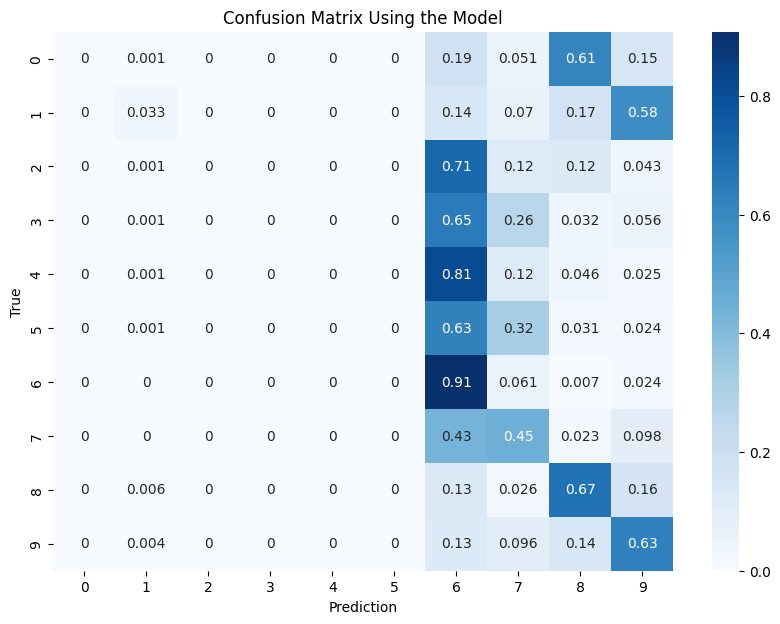

In [ ]:
y_test_pred = model3.predict(x_test)
y_test_pred_label = np.argmax(y_test_pred, axis=1)
y_test_label = np.argmax(y_test, axis=1)

fig, axs = plt.subplots(figsize=(10, 7))
conf_matrix = confusion_matrix(y_test_label, y_test_pred_label, normalize="true")

# Plotting without categories
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.ylabel("True")
plt.xlabel("Prediction")
plt.title("Confusion Matrix Using the Model")
plt.show()


As we can see, the model falsely predicted mostly 6,7, 8 and 9 for other  classes as well, hence it underperforms. For 7 being a true 7 the normalized value is 0.45 which means that even for 7 it does not predict well, however for 6 for example we have 0.91, which means that it predicts true 6s correctly, but falseley also predicts other data as 6 as well. Overall, the model performs very bad, which can also be seen from the validation accuracy that is 0.26, while we can see that the train accuracy was increasing mostly, which can potentially be a sign of overfitting.

# Understanding deep networks

*   What is the use of activation functions in network? Why is it needed?
*   We have used softmax activation function in the exercise. There are other activation functions available too. What is the difference between sigmoid activation and softmax activation?
*   What is the difference between categorical crossentropy and binary crossentropy loss?

**Solution**
Activation adds nonlinearity in the networks. Without the activation functions, the networks won't be able to capture complex hidden patterns by only using dense layer or a convolution.
When the nuerons are only 2, the sigmoid and softmax are the same. Sigmpoid is usually used for binary classification problems, while softmax is used for multi-lass classification, but both of them are used for converting the values from the neurons from the previous layer to a range from 0 to 1, which can be essentially used as a probability.
Categorical crossentropy is used for multi-class classification problems, binary crossentropy is for binary classification problems. Essentially, they are very similar, categorical crossentropy is just an extension of binary crossentropy for calculating the loss for several classes instead of two. In case of categorical crossentropy, we also use one hot encoding for the target, but for binary crossentropy we don't need it since we have only 1 for positive and 1-1= 0 for negative.

...

# Transfer Learning

It is not always necessary to train models from scratch. We can use the knowledge of networks trained on other tasks to learn the task at hand. In this exercise, we will explore the use of pre-trained weights and train on the CIFAR-10 dataset.

*   Create a base imagenet pretrained InceptionV3 model.
    *    Hint: Use tf.keras.applications to create the model
    *    Pay attention to the include_top parameter.


In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
# solution
#since the model does not allow less than 75x75 for the input size, we chose 96x96 for upsampling
inception = InceptionV3(include_top=False,weights="imagenet",input_shape=(96,96,3),classes=10)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


*    Add a global average pooling layer, followed by a fully-connected layer with 1024 neurons and then the classification layer.

In [ ]:
# solution
input_shape = (32, 32, 3)
input_tensor = Input(shape=input_shape)
x = UpSampling2D(size=(3,3))(input_tensor) # need this for inception
x = inception(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_initializer='he_uniform')(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=predictions)



*   Train the model by freezing the base model. Train only the newly added layers.
    *    Hint: Every layer has an attribute called 'trainable'
*   Compile the model and train the model for 5 epochs only with a batch size of 512.

In [ ]:
# solution
for layer in inception.layers:
    layer.trainable = False

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=512, epochs=5, validation_split=0.1)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 64s 502ms/step - accuracy: 0.2664 - loss: 2.1226 - val_accuracy: 0.5046 - val_loss: 1.4773
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - accuracy: 0.5341 - loss: 1.3927 - val_accuracy: 0.5660 - val_loss: 1.2940
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.5814 - loss: 1.2419 - val_accuracy: 0.5940 - val_loss: 1.2138
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.6125 - loss: 1.1555 - val_accuracy: 0.6150 - val_loss: 1.1626
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.6266 - loss: 1.1125 - val_accuracy: 0.6238 - val_loss: 1.1335


*    Freeze the bottom layers and unfreeze the base layers.
*    Compile and train the classifier with a very low learning rate (0.0001). Retain the batch size
*    Train the model for 20 more epochs
*    Use callbacks to (1) define "Early Stopping" and (2) save only the best model.

In [ ]:
# solution
for i, layer in enumerate(model.layers):
   print(i, layer.name)




0 input_layer_1
1 up_sampling2d
2 inception_v3
3 global_average_pooling2d
4 dense
5 dense_1


we can see that

In [ ]:
for i, layer in enumerate(model.layers):
  if i == 2:
    layer.trainable = True #the inception layer's index
  else:
    layer.trainable = False

In [ ]:
model.compile(optimizer=SGD(learning_rate = 0.0001,momentum = 0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=False
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)



In [ ]:
history5 = model.fit(x_train, y_train, batch_size=512, epochs=20, validation_split=0.1,callbacks=[early_stopping, model_checkpoint])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6355 - loss: 1.0840
Epoch 1: val_loss improved from inf to 1.13345, saving model to best_model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 241ms/step - accuracy: 0.6355 - loss: 1.0839 - val_accuracy: 0.6238 - val_loss: 1.1335
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6382 - loss: 1.0779
Epoch 2: val_loss did not improve from 1.13345
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.6382 - loss: 1.0779 - val_accuracy: 0.6238 - val_loss: 1.1335
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6417 - loss: 1.0706
Epoch 3: val_loss did not improve from 1.13345
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.6417 - loss: 1.0706 - val_accuracy: 0.6238 - val_loss: 1.1335
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6433 - loss: 1.0687
Epoch 4: val_loss did not improve from 1.13345
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.6433 - loss: 1.0688 - val_accuracy:

*    Load the best model and predict the output for the test split

313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step


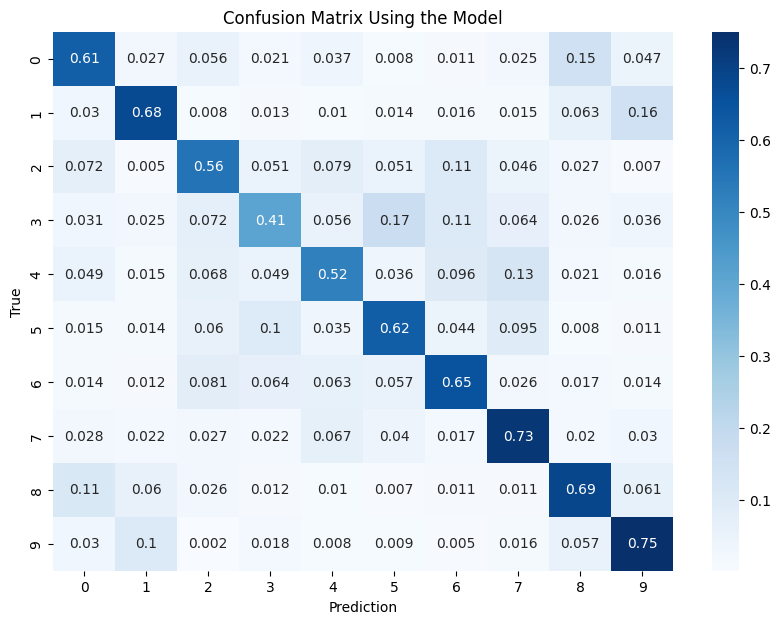

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.keras')
y_test_pred = best_model.predict(x_test)
y_test_pred_label = np.argmax(y_test_pred, axis=1)
y_test_label = np.argmax(y_test, axis=1)

fig, axs = plt.subplots(figsize=(10, 7))
conf_matrix = confusion_matrix(y_test_label, y_test_pred_label, normalize="true")

# Plotting without categories
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.ylabel("True")
plt.xlabel("Prediction")
plt.title("Confusion Matrix Using the Model")
plt.show()


*    Compare the performance of the VGG model and the Inception-V3 model.

**Solution**
The VGG model was resulting in only 0.26 accuracy while Inception-V3 results in 0.62, which indicates that the Inception model with tranfser learning performs very well. We can see the same using the confusion matrix, since for the Inception-V3 we get high values in the diagonal and very few false predictions, but in the case of VGG we were getting huge number of false predictions. This indicates that according to the accuracy and confusion matrix, it is better to use Inception-V3 using transfer learning which can also be less computationally heavy because of freezing some layers.
...

*    When do we train models from scratch? What are the potential issues in training models from scratch?

**Solution**
If we don't find a pretrained model that was trained on a dataset thatcould potentially be helpful for our case, it would be preferable to train from scratch. Especially, this can be usefull if we don't have a lack of a big dataset. Choosing to train from scratch can only be our only choise in case of new tasks that aren't solved yet ( even similar ones). Potential issues can be the big computational resource, the need for big number of data, and a potential of bad performance because of the limitation of our resources. Another disadvantage is longer training time and a high probability of overfitting when having a small dataset.

...

*    Why do we use pre-trained weights?
*    What is the difference between using random initialization and using weights from a pre-trained model?

**Solution**

We use pretrained weights for capturing some general patterns in the image, and continue training from a good start. Since the initialization is extremely essential, pretraining can help us to get into a better local minima of the loss, compared to the random initialization, which can results in the model's underperformance since becase of the bad initialization the model may not find a good local minima.

...


---

# **End of P8: Image Classification using CNN**

This notebook is part of **Deliverable 4**

Deadline for Deliverable 4 (P8 and P9) submission in CampusVirtual is: **Monday, the 2nd of December, 2024**
